
# <div align="center">**Analyze and model time series data to make predictions**</div>
## <div align="center">Forecasting virus outbreaks globally using COVID-19 data</div>

A _time series_ is a sequence of data points collected and arranged successively in equally spaced time intervals. Data is extensively collected worldwide in the form of time series. Some examples include daily opening and closing prices of stocks, hourly air temprature, monitoring heart rate continuously, hourly weather data, monthly sales figures and more. 

_Time series analysis_ involves methods for analyzing given time series data to gain meaningful information and insights that are vital for various business problems. 

**_Time series modelling_ involves creating relevant models based on past collected data to encapsulate the inherent structure and characteristics of the given time series. These models are used to predict/forecast the future values of a series.**

This project is intended to be a guide to intuitively approach any time series data-based problem. This project discusses various methods to analyze single and multiple time series. It also provides different methods that can be used to forecast a single time series and multiple time series.

**The dataset used in this notebook is _Daily confirmed cases of COVID-19 globally_**. This dataset has been made available freely as a [github repository](https://github.com/CSSEGISandData/COVID-19) by Center of Systems Science and Engineering, Johns Hopkins University (JHU CSSE). 
**The part of dataset used in this notebook is updated daily with the total COVID-19 cases for various countries and provinces. The goal is to accurately predict the global confirmed COVID-19 cases one week into the future.**


In [1]:
# Importing libraries
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt

# makes your loops 'smarter' --> shows them as a progress bar
from tqdm import tqdm
import seaborn as sns
# Hide unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
# Linear Regression
from sklearn.linear_model import LinearRegression
# pmdarima
import pmdarima as pm
# Prophet
from fbprophet import Prophet
# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Importing plotly failed. Interactive plots will not work.


In [2]:
# Cloning JHU CSSE's COVID-19 repository
!git clone https://github.com/CSSEGISandData/COVID-19.git

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [3]:
# Reading data
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.iloc[:,:102] # Selecting data from various countries from January 22, 2020 to April 28, 2020
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,996,1026,1092,1176,1279,1351,1463,1531,1703,1828
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data)

                       Province/State                    Country/Region  \
0                                 NaN                       Afghanistan   
1                                 NaN                           Albania   
2                                 NaN                           Algeria   
3                                 NaN                           Andorra   
4                                 NaN                            Angola   
5                                 NaN               Antigua and Barbuda   
6                                 NaN                         Argentina   
7                                 NaN                           Armenia   
8        Australian Capital Territory                         Australia   
9                     New South Wales                         Australia   
10                 Northern Territory                         Australia   
11                         Queensland                         Australia   
12                    Sou

Each row represents either an entire country or a Province/State of a country. Columns contain the cumulative increase in COVID-19 cases from January 22, 2020 to April 28, 2020. Each row can be converted to a time series of an individual country or one of its states.

### Plotting a country's time series
The function given below generates the time series of the row number passed to it. As it is a `pandas` dataframe, it can be easily plotted with the `plot()` method.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


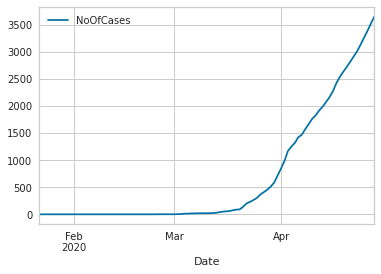

In [5]:
def get_time_series(row_no):
  row = pd.DataFrame(data.iloc[row_no,4:]).reset_index()
  row.columns = ["Date","NoOfCases"]
  row["Date"] = pd.to_datetime(row["Date"])
  return row.set_index('Date')

get_time_series(2).plot()
plt.show()

We can visually compare different time series by plotting them side-by-side or together.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


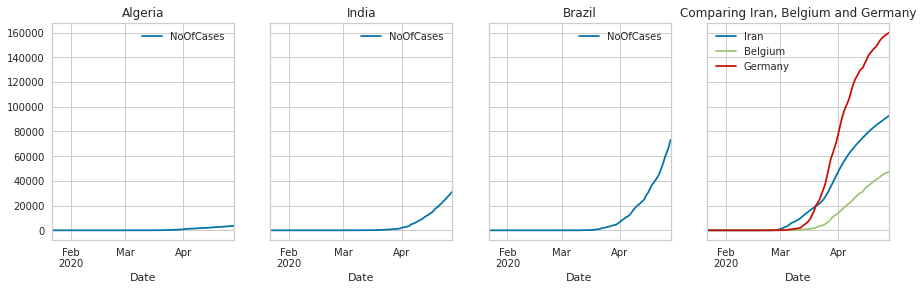

In [6]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4,sharey=True,figsize=(15,4))
get_time_series(2).plot(ax=ax1, title="Algeria")
get_time_series(131).plot(ax=ax2, title="India")
get_time_series(28).plot(ax=ax3, title="Brazil")
# next line concatenates 3 time series graphs. Displays 3 countries in one subplot. Very cool code!
multiple_series = pd.concat([get_time_series(133),get_time_series(23),get_time_series(120)],axis=1)
multiple_series.columns = ["Iran","Belgium","Germany"]
multiple_series.plot(ax=ax4, title="Comparing Iran, Belgium and Germany")
plt.show()

## Time series decomposition
We can decompose a time series into three components:

*   Trend: Tendency of time series to increase or decrease over a long period of time
*   Seasonality: Repetition of cycles in a time series
*   Residuals: Noise or random variation in the series

### Additive time series decomposition
**_Additive method_ assumes the time series follows a nearly linear trend.** 
Here, observed value is the **sum of its components(trend,seasonality,noise).**

Below is the additive time series decomposition for Germany.


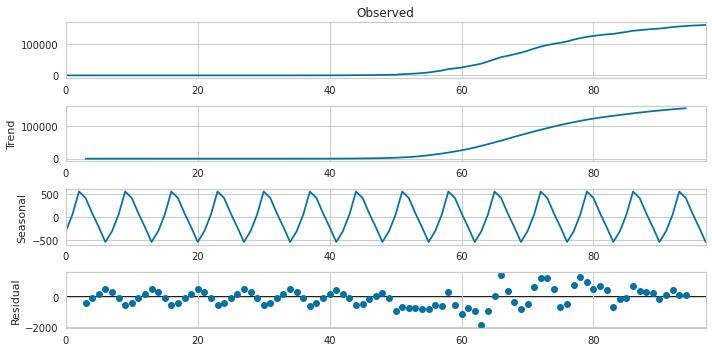

In [7]:
plt.rcParams['figure.figsize'] = [10, 5]
additive_st = seasonal_decompose(get_time_series(120).astype('float32').values,model='additive',freq=7)
additive_st.plot()
plt.show()

### Multiplicative time series decomposition
**_Multiplicative method_ assumes that the time series is non-linear or exponential.
Here, observed value is the product of its components. This is more suited to countries having exponential rise in COVID-19 cases.**

Below is the multiplicative time series decomposition for Germany.

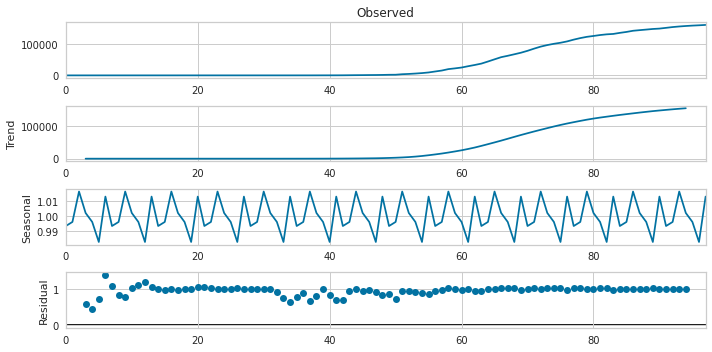

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
multiplicative_st = seasonal_decompose(get_time_series(120).add(1).astype('float32').values,model='multiplicative',freq=7)
# Added 1 to the time series as multiplicative model cannot have zero or negative values 
multiplicative_st.plot()
plt.show()

## A single time series for global confirmed cases

##### A time series for global confirmed cases has been created below by taking the sum of confirmed cases of each country on each day.

### ***This data will be used to train the models.***

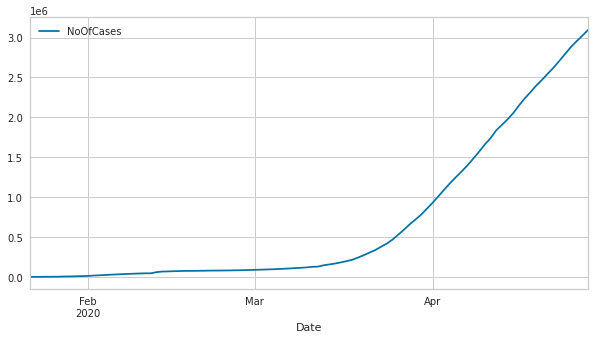

In [9]:
global_ts = data.iloc[:,4:]
global_ts = pd.DataFrame(global_ts.sum(axis=0)).reset_index()
global_ts.columns = ["Date","NoOfCases"]
global_ts["Date"] = pd.to_datetime(global_ts["Date"])
global_ts.set_index('Date', inplace=True)

global_ts.plot()
plt.show()

### Rolling and expanding window functions

#### Rolling Mean (Moving Average)
_Rolling mean_ for a given point is the arithmetic mean over a specified number of previous observations. 
**It can be used to forecast future points assuming that the future data points must be very close to mean of past data points.** 
It can also be used to deduce the trend of a time series.

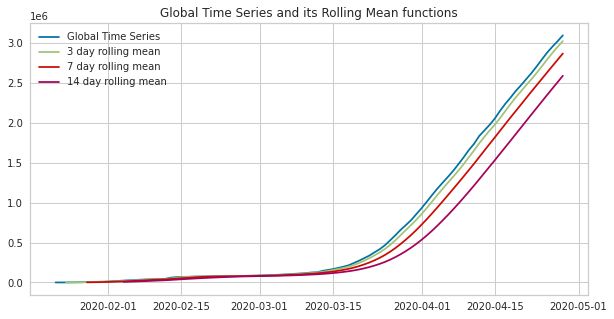

In [10]:
plt.plot(global_ts,label='Global Time Series')
plt.plot(global_ts.rolling(3).mean(),label="3 day rolling mean") # 3 day window
plt.plot(global_ts.rolling(7).mean(),label="7 day rolling mean") # 7 day window
plt.plot(global_ts.rolling(14).mean(),label="14 day rolling mean") # 14 day window
plt.title("Global Time Series and its Rolling Mean functions")
plt.legend(loc=2, ncol=1)
plt.show()

It can be observed that rolling mean **deviates from the actual data more and more as the window size increases.** 

#### Expanding Mean
Unlike rolling mean, _expanding mean_ doesn't have a fixed window size. 
For a given point, its window includes all the previous points in the time series.

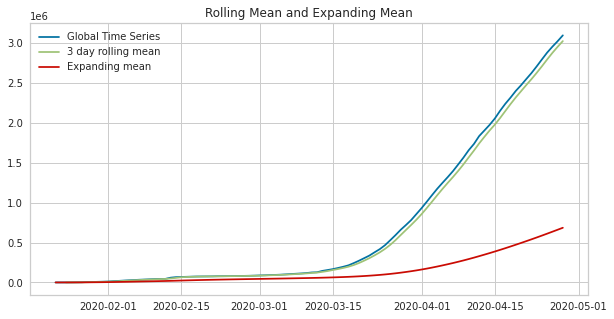

In [11]:
plt.plot(global_ts,label='Global Time Series')
plt.plot(global_ts.rolling(3).mean(),label="3 day rolling mean") # 3 day window
plt.plot(global_ts.expanding().mean(),label="Expanding mean") # Expanding Mean
plt.title("Rolling Mean and Expanding Mean")
plt.legend(loc=2, ncol=1)
plt.show()

In the global time series, **there has been an exponential rise in cases.** 
The **effect of past points** which have **much less magnitude compared to the more recent points leads to the large deviation of expanding mean** from the original time series.

## Time Series Clustering
The COVID-19 dataset contains data from almost all the countries in the world. 
It would be **interesting to know in which countries the outbreak occured in a similar way. 
An effective method to do is _KMeans Clustering_.**

### KMeans Clustering
**KMeans clustering is an unsupervised learning algorithm that divides into _k_ clusters.** Over successive iterations, _k_ **clusters are computed and adjusted so that they are surrounded by similar points** until their positions don't change anymore.

In [12]:
data_by_country = data.groupby("Country/Region").agg('sum').reset_index() # Data grouped by countries to create clusters at country level
data_by_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,996,1026,1092,1176,1279,1351,1463,1531,1703,1828
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27


**In KMeans clustering, number of clusters to be formed is specified before calculations. The `elbow` method is used to calculate this parameter.**  KElbowVisualizer class of yellowbrick package provides this feature. The figure below shows **six clusters are required** to be formed.

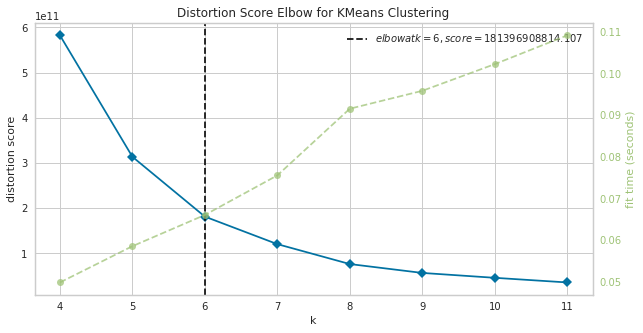

In [13]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=(4,12),metric="distortion") # Iterating over 4 to 12 clusters with 'distortion' metric
visualizer.fit(data_by_country.iloc[:,3:])
visualizer.show()

In [ ]:
# Clustering with 6 clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=0) # Defining the moodel 
y_kmeans = kmeans.fit_predict(data_by_country.iloc[:,3:]) # Estimating clusters

data_by_country["Cluster"] = y_kmeans # Assigning cluster number to individual countries

data_by_country["Cluster"].value_counts()

# PLOT THE K_MEANS.fit CLUSTERS GRAPHICALLY TO GET A BETTER SENSE OF THE DATA !

168 countries belong to Cluster `0` while clusters `1` and `3` have one country each. Let's see the country names to get a better idea

In [15]:
for i in range(1,6):
  print("Countries in cluster {} are {}".format(i,list(data_by_country[data_by_country.Cluster==i]["Country/Region"].unique())))

Countries in cluster 1 are ['US']
Countries in cluster 2 are ['France', 'Germany', 'Italy', 'Spain']
Countries in cluster 3 are ['China']
Countries in cluster 4 are ['Iran', 'Turkey', 'United Kingdom']
Countries in cluster 5 are ['Belgium', 'Brazil', 'Canada', 'India', 'Netherlands', 'Portugal', 'Russia', 'Switzerland']




*   Unsurprisingly, the U.S. and China's data is so different from others that they don't belong to any other clusters.
*   China was the first country where COVID-19 cases were confirmed. So, for initial days where every other country has zero or few cases, cases in China were rapidly increasing, hence a separate cluster for China.
*   The U.S. has now become the country with the most cases and this number is increasing rapidly each day, hence a separate cluster just for the U.S.
*   Cluster `2` has France, Germany, Italy and Spain. These countries have also been severely affected by COVID-19.
*   Cluster `4` has Iran, Turkey and United Kingdom has lesser cases than countries in Cluster `2` but still a large number of cases have been confirmed in these countries.
*   Cluster `5` has countries where daily cases started increasing later than most of the highly-affected countries. Now, these numbers are significantly high.
*   Cluster `0` has all the other countries present in the dataset.

**Clustering results can vary based on `random_state` values.** 
Also, **much better results can be achieved from clustering by normalizing data with countries' population.**

***A good way to visualize these clusters is to plot a time series aggregrated with average number of cases of all countries in the cluster daily with a 95% confidence interval.***

Confidence interval for population is computed as the sample mean $\pm$ a margin of error.

<div align="center">$\bar{x} \pm (z \times \frac{s}{\sqrt{n}}) $</div>

where $\bar{x}$ is the sample mean, s is sample standard deviation, n is the number of observations and z=1.96 for 95% confidence interval.

In [16]:
# For generating 95% confidence interval 
def get_cluster_intervals(cluster):
  df = pd.DataFrame()
  df["mean"] = cluster.mean(axis=0)
  df["lower_bound"] = df["mean"] - (1.96 * cluster.std(axis=0))/np.sqrt(len(df["mean"]))
  df["upper_bound"] = df["mean"] + (1.96 * cluster.std(axis=0))/np.sqrt(len(df["mean"]))
  df.index = global_ts.index
  return df

cluster4 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==4].iloc[:,3:-1])
cluster0 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==0].iloc[:,3:-1])
cluster2 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==2].iloc[:,3:-1])
cluster5 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==5].iloc[:,3:-1])
cluster1 = data_by_country[data_by_country["Cluster"]==1].iloc[:,3:-1].values
cluster3 = data_by_country[data_by_country["Cluster"]==3].iloc[:,3:-1].values

The following plot shows average cases for Cluster `0`:

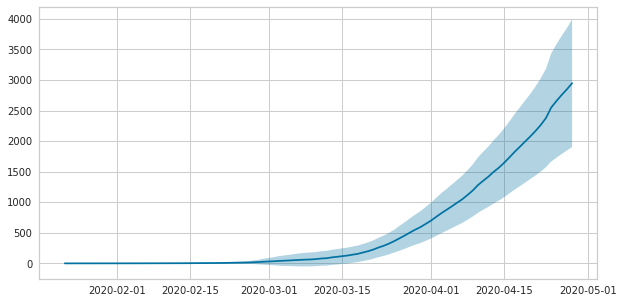

In [17]:
fig, ax = plt.subplots()
ax.plot(cluster0.index,cluster0["mean"])
ax.fill_between(cluster0.index, cluster0["lower_bound"], cluster0["upper_bound"], alpha=.3)
plt.show()

The following plot shows all clusters except the U.S. and China with 95% confidence intervals.
**Differences in the trends of the four clusters is very significant.**

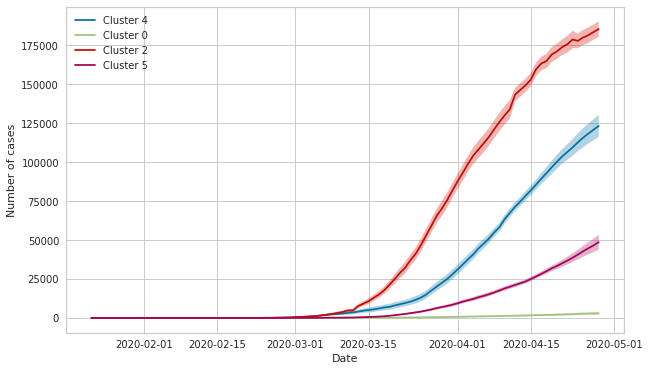

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cluster4.index,cluster4["mean"],label="Cluster 4")
ax.fill_between(cluster4.index, cluster4["lower_bound"], cluster4["upper_bound"], alpha=.3)
ax.plot(cluster0.index,cluster0["mean"],label="Cluster 0")
ax.fill_between(cluster0.index, cluster0["lower_bound"], cluster0["upper_bound"], alpha=.3)
ax.plot(cluster2.index,cluster2["mean"],label="Cluster 2")
ax.fill_between(cluster2.index, cluster2["lower_bound"], cluster2["upper_bound"], alpha=.3)
ax.plot(cluster5.index,cluster5["mean"],label="Cluster 5")
ax.fill_between(cluster5.index, cluster5["lower_bound"], cluster5["upper_bound"], alpha=.3)
#ax.plot(global_ts.index,cluster1.flatten(),label="Cluster 1 - U.S.")
#ax.plot(global_ts.index,cluster3.flatten(),label="Cluster 3 - China")
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

The following plot shows all six clusters. China has a unique plot where cases become nearly constant from around February 15. The U.S. clearly has a separate cluster due to high number of cumulative cases. 

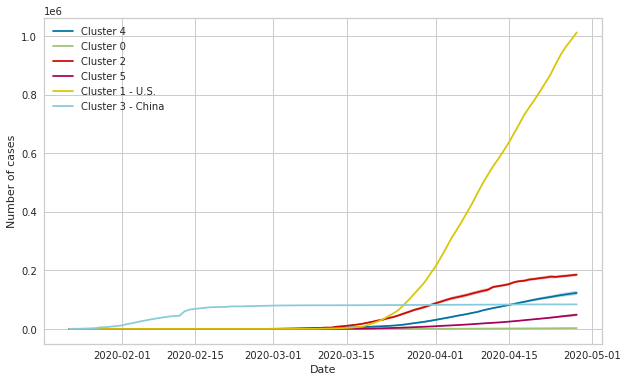

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cluster4.index,cluster4["mean"],label="Cluster 4")
ax.fill_between(cluster4.index, cluster4["lower_bound"], cluster4["upper_bound"], alpha=.3)
ax.plot(cluster0.index,cluster0["mean"],label="Cluster 0")
ax.fill_between(cluster0.index, cluster0["lower_bound"], cluster0["upper_bound"], alpha=.3)
ax.plot(cluster2.index,cluster2["mean"],label="Cluster 2")
ax.fill_between(cluster2.index, cluster2["lower_bound"], cluster2["upper_bound"], alpha=.3)
ax.plot(cluster5.index,cluster5["mean"],label="Cluster 5")
ax.fill_between(cluster5.index, cluster5["lower_bound"], cluster5["upper_bound"], alpha=.3)
ax.plot(global_ts.index,cluster1.flatten(),label="Cluster 1 - U.S.")
ax.plot(global_ts.index,cluster3.flatten(),label="Cluster 3 - China")
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend()

### Time Series Modelling

#### AR models
The `autoregressive` (`AR`) model specifies that the output variable depends linearly on its own previous values and on a _stochastic_ term (an imperfectly predictable term); thus the model is in the form of a stochastic difference equation.

##### AR(1) model
R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ε<sub>t</sub>

Today's returns = mean + yesterday's return + noise

##### AR(2) model
R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>


##### AR(3) model
R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

#### MA models
The `moving-average` model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

##### MA(1) model

R<sub>t</sub> = μ + 1ε<sub>t</sub> + θϵ<sub>t-1</sub>

It translates to: Today's returns = mean + today's noise + yesterday's noise.

#### ARIMA model
An `ARIMA` model combines the `AR` models and `MA` models with an initial differencing parameter(I). These models are effective in forecasting future data points for a stationary series. `ARIMA` model has three parameters:

*   _p_: number of time lags of the `AR` model.
*   _d_: degree of differencing (number of times past data had to be subtracted from the data to make it stationary). It can be 0, 1 or 2.
*   _q_: number of time lags of the `MA` model.

In [20]:
# Creating a training and test set to predict 7 days into the future
train = global_ts.iloc[:-7,:]
test = global_ts.iloc[-7:,:]

#### Autocorrelation and Partial Autocorrelation
_Autocorrelation_ can be defined as the correlation of time series observations with their lagged forms. It describes how much a data point depends on its previous data points.

_Partial Autocorrelation_ can be defined as the correlation of time series observations with their lagged forms without the effect of intervening obersvations.

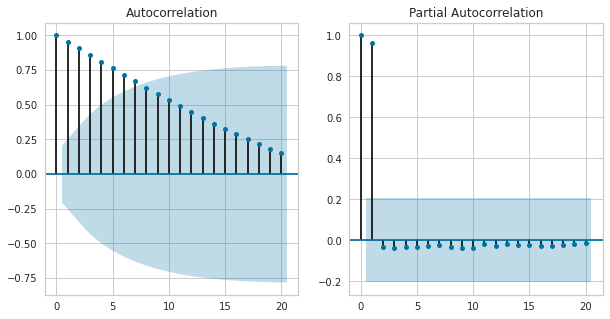

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(train.iloc[:,0].values, ax=axes[0])
plot_pacf(train.iloc[:,0].values, ax=axes[1])
plt.show()

For a series with zero order differencing, Autocorrelation plot shows significant lags till 7th lag which can be the _q(MA)_ parameter of the `ARIMA` model. Partial autocorrelation plot shows significant lags till the first lag, which can be the _p(AR)_ parameter of the `ARIMA` model. 

#### Augment Dickey-Fuller Test
An _augmented Dickey–Fuller_ test (ADF) tests the null hypothesis that a unit root is present in a time series sample. Unit root being present means time series is not stationary. Unit root is present when $\alpha$ = 1.

At a significance level of 0.05, we have:

`Null hypothesis H<sub>0</sub> : $\alpha$ = 1`

`Alternative hypothesis H<sub>A</sub> : $\alpha$ $\neq$ 1`

For a series to be stationary, $\alpha$ $\neq$ 1. To achieve this, we subtract previous values from series again and again, and perform ADF tests to get a _p-value_ less than 0.05 so we can reject the null hypothesis.

Number of times differencing was done determines the _d_ parameter of an `ARIMA` model:

In [22]:
series = train.iloc[:,0]
for i in range(0,4):
  print("p-value after differencing {} times: {}".format(i,adfuller(series)[1]))
  series = series.diff().dropna()

p-value after differencing 0 times: 0.9985004688411667
p-value after differencing 1 times: 0.5992939128155006
p-value after differencing 2 times: 0.5730251550462088
p-value after differencing 3 times: 0.005372888699045583


Differencing parameter _d_ should be `3` but we can choose a maximum value of `2` for the given package. 

Following is a plot that shows autocorrelation and partial autocorrelation plots of 0th, 1st, 2nd and 3rd order differencing: 

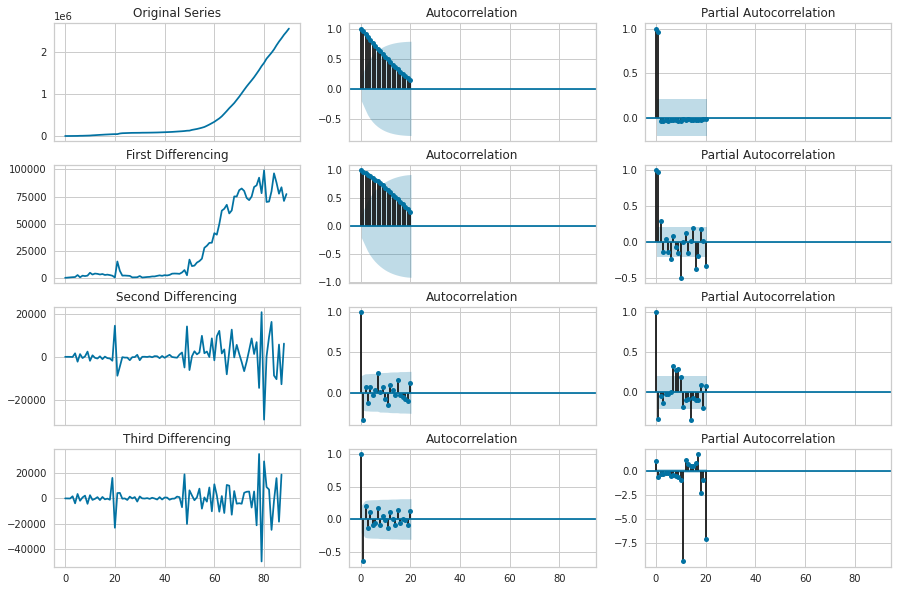

In [23]:
fig, axes = plt.subplots(4, 3, figsize=(15,10), sharex=True)
axes[0, 0].plot(train.iloc[:,0].values)
axes[0, 0].set_title('Original Series')
plot_acf(train.iloc[:,0].values, ax=axes[0, 1])
plot_pacf(train.iloc[:,0].values, ax=axes[0, 2])
axes[1, 0].plot(train.iloc[:,0].diff().dropna().values)
axes[1, 0].set_title('First Differencing')
plot_acf(train.iloc[:,0].diff().dropna().values, ax=axes[1, 1])
plot_pacf(train.iloc[:,0].diff().dropna().values, ax=axes[1, 2])
axes[2, 0].plot(train.iloc[:,0].diff().diff().dropna().values)
axes[2, 0].set_title('Second Differencing')
plot_acf(train.iloc[:,0].diff().diff().dropna().values, ax=axes[2, 1])
plot_pacf(train.iloc[:,0].diff().diff().dropna().values, ax=axes[2, 2])
axes[3, 0].plot(train.iloc[:,0].diff().diff().diff().dropna().values)
axes[3, 0].set_title('Third Differencing')
plot_acf(train.iloc[:,0].diff().diff().diff().dropna().values, ax=axes[3, 1])
plot_pacf(train.iloc[:,0].diff().diff().diff().dropna().values, ax=axes[3, 2])
plt.show()

From the above plot, the best model we can make is `ARIMA(1,2,1)`.

In [24]:
modelArima121 = ARIMA(train.values,order=(1,2,1)) # p=1, d=2, q=1
modelArima121_fit = modelArima121.fit(disp=0)  
print(modelArima121_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   89
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -902.115
Method:                       css-mle   S.D. of innovations           6102.319
Date:                Tue, 12 May 2020   AIC                           1812.229
Time:                        09:53:39   BIC                           1822.184
Sample:                             2   HQIC                          1816.242
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        867.6404    425.905      2.037      0.042      32.883    1702.398
ar.L1.D2.y    -0.0399      0.331     -0.120      0.904      -0.689       0.609
ma.L1.D2.y    -0.3198      0.319     -1.004      0.3

Intuition aside, it is best to try all possible models to know the best parameters.

In [25]:
# A function to get results from ARIMA models
def get_arima_results(order,train,test,prints=True):
  history = train.values
  pred = []
  for i in range(len(test)):
    model = ARIMA(history,order=order)
    fitted = model.fit(disp=0)
    y_pred = fitted.forecast()[0]
    pred.append(y_pred)
    history = np.append(history,y_pred).reshape(history.shape[0]+1,-1)
  if prints:
    print(fitted.summary())
  rmse = np.sqrt(mean_squared_error(test.values,np.array(pred)))
  mae = mean_absolute_error(test.values,np.array(pred))
  mape = mean_absolute_percentage_error(test.values,np.array(pred))
  aic = fitted.aic
  bic = fitted.bic
  return rmse, mae, mape, aic, bic

# Using above function we can iterate over ARIMA models of different orders to get the best model
arima_results = {}
for i in tqdm([0,1,2,3,4]):
  for j in [0,1,2]:
    for k in [0,1,2,3,4,]:
      try:
        order = "("+str(i)+","+str(j)+","+str(k)+")"
        rmse, mae, mape, aic, bic = get_arima_results((i,j,k),train,test,prints=False)
        arima_results[order] = [rmse, mae, mape, aic, bic]
      except:
        pass
    
arima_results = pd.DataFrame(arima_results).T.reset_index()
arima_results.columns = ["Order","RMSE","MAE","MAPE","AIC","BIC"]

100%|██████████| 5/5 [01:46<00:00, 21.30s/it]


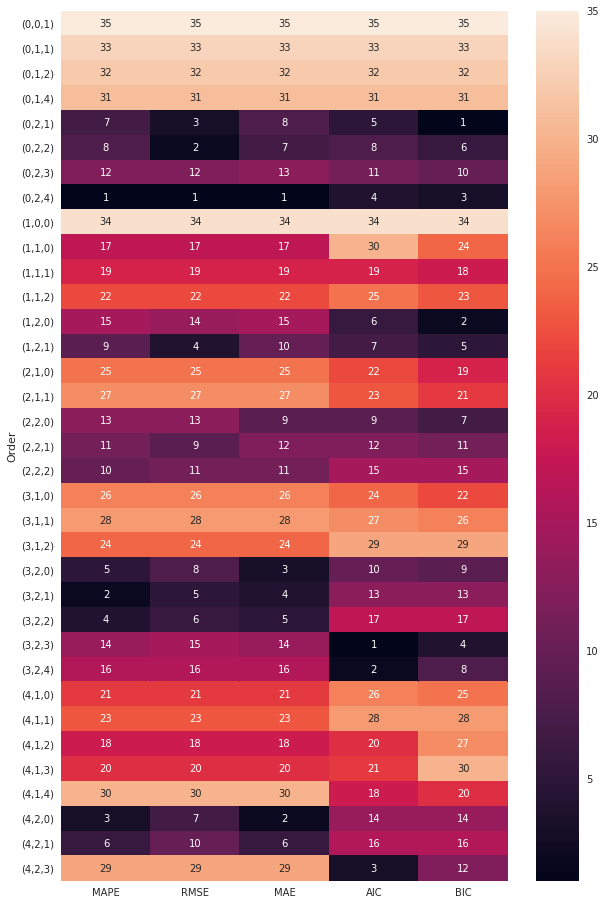

In [26]:
# Ranking different metrics
arima_heatmap = pd.DataFrame()
arima_heatmap["Order"] = arima_results["Order"]
arima_heatmap["MAPE"] = arima_results["MAPE"].rank(method="max")
arima_heatmap["RMSE"] = arima_results["RMSE"].rank(method="max")
arima_heatmap["MAE"] = arima_results["MAE"].rank(method="max")
arima_heatmap["AIC"] = arima_results["AIC"].rank(method="max")
arima_heatmap["BIC"] = arima_results["BIC"].rank(method="max")

# Generating a heatmap to get best results
fig,ax = plt.subplots(figsize=(10,16))
sns.heatmap(arima_heatmap.set_index("Order"),annot=True,ax=ax)
plt.show()

In [27]:
print("Best ranked model on the basis of metrics MAE, RMSE and MAPE")
arima_results[arima_results["Order"]=="(4,2,3)"]

Best ranked model on the basis of metrics MAE, RMSE and MAPE


,Order,RMSE,MAE,MAPE,AIC,BIC
34,"(4,2,3)",28769.284797,23981.34951,0.809577,1920.588673,1943.573565


In [28]:
print("Best ranked model on the basis of AIC")
arima_results[arima_results["Order"]=="(4,2,4)"]

Best ranked model on the basis of AIC


,Order,RMSE,MAE,MAPE,AIC,BIC


In [29]:
print("Best ranked model on the basis of BIC")
arima_results[arima_results["Order"]=="(0,2,1)"]

Best ranked model on the basis of BIC


,Order,RMSE,MAE,MAPE,AIC,BIC
4,"(0,2,1)",9875.280843,8507.846599,0.291263,1925.672433,1933.334063


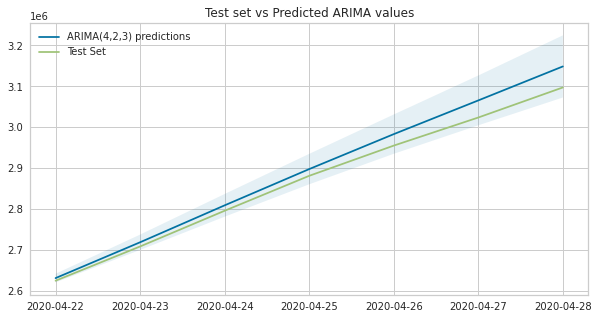

In [30]:
modelArima423 = ARIMA(train.values,order=(4,2,3))
modelArima423_fit = modelArima423.fit(disp=0)  
forecast423 = modelArima423_fit.forecast(7)
plt.plot(test.index,forecast423[0],label="ARIMA(4,2,3) predictions")
plt.fill_between(test.index,[i[0] for i in forecast423[2].tolist()],[i[1] for i in forecast423[2].tolist()], alpha=0.1)
plt.plot(test, label="Test Set")
plt.title("Test set vs Predicted ARIMA values")
plt.legend(loc=2)
plt.show()

For now, the best model is of the order `(4,2,3)` as it is ranked first for three out of five metrics

#### Auto Arima
`pmdarima` package provides the `auto_arima` model that automatically returns the best model parameters

In [31]:
model = pm.auto_arima(train.values, start_p=1, start_q=1, test='adf',max_p=3, max_q=3,
                      m=7, d=None, seasonal=True, start_P=0, D=None, trace=True, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,1,7) [intercept=True]; AIC=1799.759, BIC=1812.202, Time=0.458 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=True]; AIC=1819.164, BIC=1824.141, Time=0.014 seconds
Fit ARIMA(1,2,0)x(1,0,0,7) [intercept=True]; AIC=1801.593, BIC=1811.548, Time=0.086 seconds
Fit ARIMA(0,2,1)x(0,0,1,7) [intercept=True]; AIC=1800.885, BIC=1810.839, Time=0.219 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=False]; AIC=1818.761, BIC=1821.249, Time=0.013 seconds
Fit ARIMA(1,2,1)x(0,0,0,7) [intercept=True]; AIC=1812.537, BIC=1822.492, Time=0.065 seconds
Fit ARIMA(1,2,1)x(1,0,1,7) [intercept=True]; AIC=1803.828, BIC=1818.760, Time=0.282 seconds
Fit ARIMA(1,2,1)x(0,0,2,7) [intercept=True]; AIC=1803.473, BIC=1818.405, Time=0.560 seconds
Fit ARIMA(1,2,1)x(1,0,0,7) [intercept=True]; AIC=1803.456, BIC=1815.899, Time=0.150 seconds
Fit ARIMA(1,2,1)x(1,0,2,7) [intercept=True]; AIC=1805.403, BIC=1822.824, Time=0.871 seconds
Fit ARIMA(1,2,0)x(0,0,1,7) [intercep

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   91
Model:             SARIMAX(1, 2, 0)x(0, 0, [1], 7)   Log Likelihood                -895.772
Date:                             Tue, 12 May 2020   AIC                           1799.543
Time:                                     09:55:33   BIC                           1809.498
Sample:                                          0   HQIC                          1803.555
                                              - 91                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1162.4020    869.521      1.337      0.181    -541.827    2866.631
ar.L1         -0.4395      

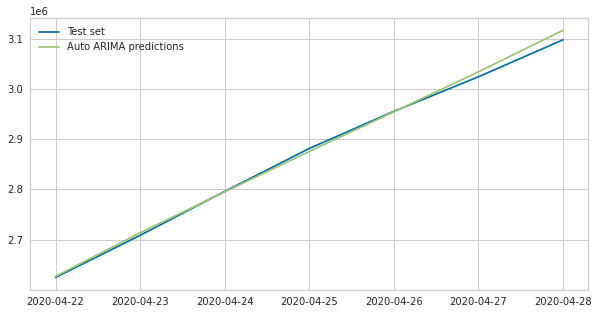

In [32]:
print(model.summary()) # best model
model.fit(train.values)  # Fitting model
preds = model.predict(n_periods=7) # Making predictions for next 7 days i.e., the test set
print("Root Mean Squared Error for best model: {}".format(np.sqrt(mean_squared_error(test.values,preds))))
print("Mean Absolute Error for best model: {}".format(mean_absolute_error(test.values,preds)))
print("Mean Absolute Percentage Error for best model: {}".format(mean_absolute_percentage_error(test.values,preds)))
plt.plot(test, label="Test set")
plt.plot(test.index,preds, label="Auto ARIMA predictions")
plt.legend()
plt.show()

RMSE, MAE, AIC and BIC have significantly decreased, but MAPE has increased substantially when compared to previous best model.

The best model above is actually a `SARIMA` model, which is an `ARIMA` model with a seasonal component. `SARIMA` models have seasonal parameters (_P_,_D_,_Q_,_M_) where _M_ is the frequency and _P_, _D_, _Q_ are `AR`, differencing and `MA` terms for the seasonal component of the time series, respectively.

#### Linear Regression
While `ARIMA` and `SARIMA` give reasonably good results, a `linear` regression model with lag and moving average based features is also a effective way for forecasting data points.

In [33]:
lr_global = global_ts.reset_index()

# Lag features of last 
for i in range(1,15):
  lr_global["lag{}".format(i)] = lr_global["NoOfCases"].shift(i)

# Date based features
lr_global["day"] = lr_global["Date"].dt.day
lr_global["month"] = lr_global["Date"].dt.month

# Moving average based features
lr_global["rolling_7_mean"] = lr_global["NoOfCases"].rolling(7).mean()
lr_global["rolling_14_mean"] = lr_global["NoOfCases"].rolling(14).mean()
lr_global["rolling_7_std"] = lr_global["NoOfCases"].rolling(7).std()
lr_global["rolling_14_std"] = lr_global["NoOfCases"].rolling(14).std()
lr_global["rolling_7_var"] = lr_global["NoOfCases"].rolling(7).var()
lr_global["rolling_14_var"] = lr_global["NoOfCases"].rolling(14).var()

lr_global.tail()

,Date,NoOfCases,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,lag13,lag14,day,month,rolling_7_mean,rolling_14_mean,rolling_7_std,rolling_14_std,rolling_7_var,rolling_14_var
93,2020-04-24,2795731,2708403.0,2624608.0,2549046.0,2471727.0,2400787.0,2317243.0,2239634.0,2151792.0,...,1736032.0,1657950.0,24,4,2.552506e+06,2.269021e+06,170081.120943,338228.379621,2.892759e+10,1.143984e+11
94,2020-04-25,2881140,2795731.0,2708403.0,2624608.0,2549046.0,2471727.0,2400787.0,2317243.0,2239634.0,...,1835145.0,1736032.0,25,4,2.633063e+06,2.350815e+06,173585.224092,337881.307157,3.013183e+10,1.141638e+11
95,2020-04-26,2955033,2881140.0,2795731.0,2708403.0,2624608.0,2549046.0,2471727.0,2400787.0,2317243.0,...,1905160.0,1835145.0,26,4,2.712241e+06,2.430807e+06,176361.027781,338970.331366,3.110321e+10,1.149009e+11
96,2020-04-27,3023722,2955033.0,2881140.0,2795731.0,2708403.0,2624608.0,2549046.0,2471727.0,2400787.0,...,1975566.0,1905160.0,27,4,2.791098e+06,2.510704e+06,174291.035284,337363.706064,3.037736e+10,1.138143e+11
97,2020-04-28,3097229,3023722.0,2955033.0,2881140.0,2795731.0,2708403.0,2624608.0,2549046.0,2471727.0,...,2055424.0,1975566.0,28,4,2.869409e+06,2.590823e+06,170520.013208,333669.358594,2.907707e+10,1.113352e+11


In [34]:
# Training and test sets for Linear Model
# Starting from 15th observation as first 14 rows have null values due to lag and moving average features
lr_train = lr_global.iloc[14:-7,:]
lr_test = lr_global.iloc[-7:,:]

lr_train.set_index("Date",inplace=True)
lr_test.set_index("Date",inplace=True)

In [35]:
reg = LinearRegression().fit(lr_train.drop(["NoOfCases"],axis=1), lr_train["NoOfCases"]) # fitting the lr model
lr_preds = reg.predict(lr_test.drop(["NoOfCases"],axis=1)) # getting predictions

In [36]:
print("Root Mean Squared Error for best model: {:.6f}".format(np.sqrt(mean_squared_error(lr_test["NoOfCases"].values,lr_preds))))
print("Mean Absolute Error for best model: {:.6f}".format(mean_absolute_error(lr_test["NoOfCases"].values,lr_preds)))
print("Mean Absolute Percentage Error for best model: {:.11f}".format(mean_absolute_percentage_error(lr_test["NoOfCases"].values,lr_preds)))

Root Mean Squared Error for best model: 0.000043
Mean Absolute Error for best model: 0.000043
Mean Absolute Percentage Error for best model: 0.00000000148


For the `linear` model, all errors are negligible. This is clearly the best model.

### Time Series Cross Validation
To be more confident about the results, we can use time series cross validation techniques. The performance of a model can be tested by model training on variable training data sizes. 

Here, the `auto_arima` model has been trained on variable training sizes for the same test set.



In [37]:
train_13w = train # Training for 13 weeks
train_11w = train[7*2:] # Training for 11 weeks
train_9w = train[7*4:] # Training for 9 weeks
train_7w = train[7*6:] # Training for 7 weeks
train_5w = train[7*8:] # Training for 5 weeks
pred_list = []
rmse_list = []
mae_list = []
mape_list = []
week = 13
for i in tqdm([train_13w,train_11w,train_9w,train_7w,train_5w]):
  model = pm.auto_arima(train.values, start_p=1, start_q=1, test='adf',max_p=3, max_q=3,
                      m=7, d=None, seasonal=True, start_P=0, D=None, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)
  model.fit(i.values)
  preds = model.predict(n_periods=7)
  pred_list.append(preds)
  rmse = np.sqrt(mean_squared_error(test.values,preds))
  mae = mean_absolute_error(test.values,preds)
  mape = mean_absolute_percentage_error(test.values,preds)
  print(" Root Mean Squared Error by training on {} weeks: {}".format(week,rmse))
  print(" Mean Absolute Error by training on {} weeks: {}".format(week,mae))
  print(" Mean Absolute Percentage Error by training on {} weeks: {}".format(week,mape))
  week = week-2
  rmse_list.append(rmse)
  mae_list.append(mae)
  mape_list.append(mape)
print("\nAverage mean_absolute_percentage_error: {}".format(np.mean(rmse_list)))
print("mean_absolute_percentage_error after averaging predictions: {}".format(np.sqrt(mean_squared_error(test.values,np.mean(pred_list,axis=0)))))
print("Average mean_absolute_error: {}".format(np.mean(mae_list)))
print("mean_absolute_error after averaging predictions: {}".format(mean_absolute_error(test.values,np.mean(pred_list,axis=0))))
print("Average mean_absolute_percentage_error: {}".format(np.mean(mape_list)))
print("mean_absolute_percentage_error after averaging predictions: {}".format(mean_absolute_percentage_error(test.values,np.mean(pred_list,axis=0))))

 20%|██        | 1/5 [00:04<00:19,  4.76s/it]

 Root Mean Squared Error by training on 13 weeks: 8665.132032761241
 Mean Absolute Error by training on 13 weeks: 6268.421465474447
 Mean Absolute Percentage Error by training on 13 weeks: 6.434741951502003


 40%|████      | 2/5 [00:09<00:14,  4.81s/it]

 Root Mean Squared Error by training on 11 weeks: 9610.472285465172
 Mean Absolute Error by training on 11 weeks: 7020.734147325957
 Mean Absolute Percentage Error by training on 11 weeks: 6.458476151300016


 60%|██████    | 3/5 [00:14<00:09,  4.70s/it]

 Root Mean Squared Error by training on 9 weeks: 15302.492170852467
 Mean Absolute Error by training on 9 weeks: 10430.13793299427
 Mean Absolute Percentage Error by training on 9 weeks: 6.56749180409673


 80%|████████  | 4/5 [00:19<00:04,  4.89s/it]

 Root Mean Squared Error by training on 7 weeks: 21612.889637790864
 Mean Absolute Error by training on 7 weeks: 13950.589320114814
 Mean Absolute Percentage Error by training on 7 weeks: 6.672774440204453


100%|██████████| 5/5 [00:24<00:00,  4.89s/it]

 Root Mean Squared Error by training on 5 weeks: 20656.766181005514
 Mean Absolute Error by training on 5 weeks: 13511.52944404399
 Mean Absolute Percentage Error by training on 5 weeks: 6.663015725512242

Average mean_absolute_percentage_error: 15169.55046157505
mean_absolute_percentage_error after averaging predictions: 14972.38348806187
Average mean_absolute_error: 10236.282461990695
mean_absolute_error after averaging predictions: 10131.191682513603
Average mean_absolute_percentage_error: 6.559300014523089
mean_absolute_percentage_error after averaging predictions: 6.5587919671173


As we decrease training data, errors increase by a significant margin. `auto_arima` models will be more effective with more reliable performance with a larger dataset.

#### Facebook Prophet
`Prophet` is a procedure for time series forecasting developed by Facebook. It works best for data with strong seasonal effects.

In [38]:
fbp_train = train.reset_index()
fbp_train.columns = ["ds","y"] # Specific column names are required
fbp_model = Prophet(daily_seasonality=True)
fbp_model.fit(fbp_train)

future = fbp_model.make_future_dataframe(periods=7) # Forecasting for last 7 days
forecast = fbp_model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Root Mean Squared Error for Prophet model: 14940.388834833399
Mean Absolute Error for Prophet model: 12958.964036871146
Mean Absolute Percentage Error for Prophet model: 6.499429989502685


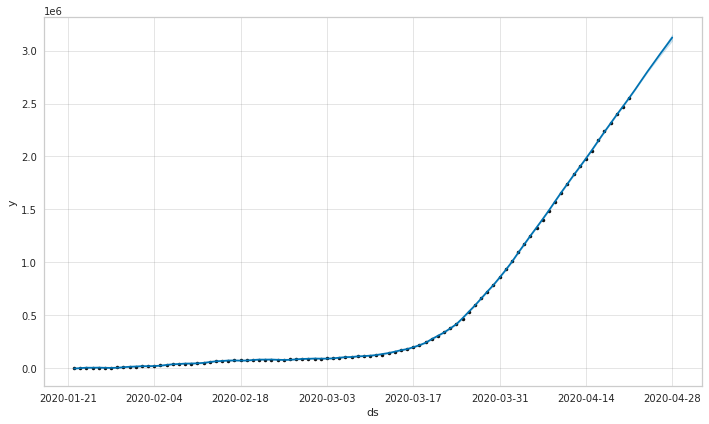

In [39]:
print("Root Mean Squared Error for Prophet model: {}".format(np.sqrt(mean_squared_error(test.values,forecast.tail(7)["yhat"].values))))
print("Mean Absolute Error for Prophet model: {}".format(mean_absolute_error(test.values,forecast.tail(7)["yhat"].values)))
print("Mean Absolute Percentage Error for Prophet model: {}".format(mean_absolute_percentage_error(test.values,forecast.tail(7)["yhat"].values)))
fig = fbp_model.plot(forecast)

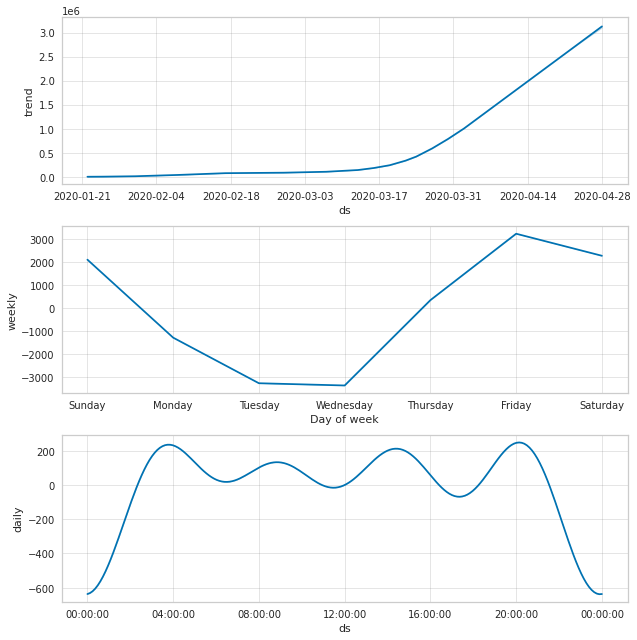

In [40]:
fig = fbp_model.plot_components(forecast)

Its performance is very comparable to the `auto_arima` model but it is a much simpler implementation. Weekly component shows a drop in cases on Tuesday and Wednesday before increasing again during the weekend.

### Multiple Time Series Forecasting

#### VARMAX model
Time series with multiple columns can also be forecasted using the `VARMAX` model (`Vector Autoregressive Moving Average with eXogenous regressors` model). These are like `ARIMA` models but without a degree of differencing parameter and can do forecasting for multiple time series columns. This has been used below to forecast future predictions for countries in Cluster `2`, (i.e., France, Germany, Italy and Spain).

In [41]:
c2 = data_by_country[data_by_country["Cluster"]==2].set_index("Country/Region").iloc[:,2:-1].T.reset_index()
c2["Date"] = pd.to_datetime(c2["index"])
c2.drop(["index"],axis=1,inplace=True)
c2.set_index("Date",inplace=True)

c2_train = c2.iloc[:-7,:]
c2_test = c2.iloc[-7:,:]

In [ ]:
best_model = {
    "best_rmse": [float("inf"),(0,0)],
    "best_mae": [float("inf"),(0,0)],
    "best_mape": [float("inf"),(0,0)],
    "best_aic": [float("inf"),(0,0)],
    "best_bic": [float("inf"),(0,0)]
}
# Iterative approach to find best model
for i in tqdm(range(1,5)): # Taking all AR and MA parameter combination from 1 to 4
  for j in range(1,5):
    if i == 0 and j== 0:
      pass
    else:
      mod = sm.tsa.VARMAX(c2_train.astype('float32'), order=(i,j), trend='t')
      res = mod.fit(maxiter=100, disp=False)
      varmax_forecast = res.forecast(7)
      varmax_rmse = np.sqrt(mean_squared_error(c2_test.values.flatten(),varmax_forecast.values.flatten()))
      varmax_mae = mean_absolute_error(c2_test.values.flatten(),varmax_forecast.values.flatten())
      varmax_mape = mean_absolute_percentage_error(c2_test.values.flatten(),varmax_forecast.values.flatten())
      varmax_aic = res.aic
      varmax_bic = res.bic
      if varmax_rmse < best_model["best_rmse"][0]:
        best_model["best_rmse"] = [varmax_rmse,(i,j)]
      if varmax_mae < best_model["best_mae"][0]:
        best_model["best_mae"] = [varmax_mae,(i,j)]
      if varmax_mape < best_model["best_mape"][0]:
        best_model["best_mape"] = [varmax_mape,(i,j)]
      if varmax_aic < best_model["best_aic"][0]:
        best_model["best_aic"] = [varmax_aic,(i,j)]
      if varmax_bic < best_model["best_bic"][0]:
        best_model["best_bic"] = [varmax_bic,(i,j)]
    print(best_model)

  0%|          | 0/4 [00:00<?, ?it/s]

{'best_rmse': [27232.226787338124, (1, 1)], 'best_mae': [24986.235492627526, (1, 1)], 'best_mape': [13.84759545993208, (1, 1)], 'best_aic': [7383.616470094896, (1, 1)], 'best_bic': [7499.116007394671, (1, 1)]}
{'best_rmse': [22412.666894191334, (1, 2)], 'best_mae': [20957.001158965926, (1, 2)], 'best_mape': [11.615881865139446, (1, 2)], 'best_aic': [7135.980055063205, (1, 2)], 'best_bic': [7291.65334446725, (1, 2)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6752.6260060970235, (1, 3)], 'best_bic': [6948.473047605337, (1, 3)]}


 25%|██▌       | 1/4 [04:22<13:08, 262.76s/it]

{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6659.350127650441, (1, 4)], 'best_bic': [6895.370921263025, (1, 4)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6659.350127650441, (1, 4)], 'best_bic': [6895.370921263025, (1, 4)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6659.350127650441, (1, 4)], 'best_bic': [6895.370921263025, (1, 4)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6659.350127650441, (1, 4)], 'best_bic': [6895.370921263025, (1, 4)]}


 50%|█████     | 2/4 [10:45<09:57, 298.83s/it]

{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6659.350127650441, (1, 4)], 'best_bic': [6895.370921263025, (1, 4)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6085.488979356094, (3, 1)], 'best_bic': [6281.336020864408, (3, 1)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6085.488979356094, (3, 1)], 'best_bic': [6281.336020864408, (3, 1)]}
{'best_rmse': [3828.8929646755428, (1, 3)], 'best_mae': [3099.627766662718, (1, 3)], 'best_mape': [1.6692351020500424, (1, 3)], 'best_aic': [6085.488979356094, (3, 1)], 'best_bic': [6281.336020864408, (3, 1)]}


In [ ]:
mod = sm.tsa.VARMAX(c2_train.astype('float32'), order=best_model["best_mape"][1], trend='t')
res = mod.fit(maxiter=100, disp=False)
varmax_forecast = res.forecast(7)

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,8),sharex=True)
ax1.plot(c2_test["France"],label="Test set")
ax1.plot(varmax_forecast["France"],label="VARMAX predictions")
ax1.set_title("France")
ax1.legend(loc=2)
ax2.plot(c2_test["Germany"],label="Test set")
ax2.plot(varmax_forecast["Germany"],label="VARMAX predictions")
ax2.set_title("Germany")
ax2.legend(loc=2)
ax3.plot(c2_test["Italy"],label="Test set")
ax3.plot(varmax_forecast["Italy"],label="VARMAX predictions")
ax3.set_title("Italy")
ax3.legend(loc=2)
ax4.plot(c2_test["Spain"],label="Test set")
ax4.plot(varmax_forecast["Spain"],label="VARMAX predictions")
ax4.set_title("Spain")
ax4.legend(loc=2)
plt.show()

Although it has taken a long time to select the best model, the individual forecasts don't deviate much.

### Further Reading
Here are some other interesting topics on time series:

*   Exponential smoothing
*   ARCH and GARCH models
*   LSTMs for time series forecasting
*   Dynamic Linear Models

